<a href="https://colab.research.google.com/github/koba341/AutoML/blob/main/FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import needed packages
import pandas as pd
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
import numpy as np
from time import time
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from heapq import nlargest
!pip install gpytorch
!pip install scikit-optimize
import gpytorch
import torch
!pip install pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 3.9 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=a3c92c724f5130abb442de515503041f449ec2973cc8994f03d956ba111fce9a
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 3.6 MB/s 
     |████████████████████████████████| 239 kB 40.8 MB/s 


# Feature Selection

# Inhaltsverzeichnis
I. Bemerkungen \\
II. Import Datasets \\
III. Gaussprozess, RandomForest (kein RandomForest Algorithmus momentan)

1. Lasso \\
Lasso Übersicht, LassoCV, Lasso mit HPO, Lasso mit NSGAII
2. Ridge \\
Ridge Übersicht, RidgeCV, Ridge mit HPO, Ridge mit NSGAII
3. ElasticNet \\
ElasticNet Übersicht, ElasticNetCV, ElasticNet mit HPO, ElasticNet mit NSGAII

**Bemerkungen 17.06.**
1.   Wenn etwas programmiert wird, Hintergrundinformationen mitliefern: Wie funktioniert ein Gaussprozess zb... Zu RandomForest zB nichts schreiben, da sehr bekannt 
2.   ~Hperparametersuche mit AutoML und NSGA II~
3.   ~Diagramme wie https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py einbauen und erklären~
4.   Bei allen Verfahrne nochmal Algorithmus kurz zeigen und Entscheidungsprozess für die selected Features erklären + Diagramme
5.   Github auf Privat stellen, Farzad Access geben
6.   R2 definieren - welches R2 wird genutzt? Manche geben negative Werte, manche nicht - unbedingt definieren. :https://en.wikipedia.org/wiki/Coefficient_of_determination Von 1 bis - unendlich
7.   ~Bei Modellerstellung: Immer NSGA II (+ gewünschte Modelle) und AutoML zuerst nutzen - Hyperparameter Optimization~
8.   Ensembles auch erstellen. Ensembles mit gemischten Algorithmen bei den traditionellen Methoden. Alles nutzen. Nächster Schritt: Ensembles mit neuronalen Netzwerken aus NAS.
9.  ~Beide Concrete Datensätze nutzen (das mit 1000 und 100 Datenpunkten)~






*   Auswahl Hyperparameter
*   Training mit Feature Selection
*   Entscheidungsprozess bei Lasso, Ridge und Elastic



A search consists of:

    an estimator (regressor or classifier such as sklearn.svm.SVC());

    a parameter space;

    a method for searching or sampling candidates;

    a cross-validation scheme; and

    a score function.

# Import Datasets
Es gibt zwei Datensätze. Alle Algorithmen wurden mit dem kleinen slump_test.csv Datenset durchgeführt.

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AutoML/slump_test.csv")
X = data.iloc[:, 1:10].to_numpy()
y = data.iloc[:, 10].to_numpy()
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, train_size=0.90, random_state=1) # create training and test dataset. 
import warnings
data_cols = data.columns.copy().tolist()
data_cols.remove('No')
data_cols.remove('Compressive Strength (28-day)(Mpa)')

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AutoML/Concrete_Data.xls', engine='xlrd')
X = data.iloc[:, 0:8].to_numpy()
y = data.iloc[:, 8].to_numpy()
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, train_size=0.90, random_state=1)

# Gaussprozess, Random Forest

Gaussprozessregression mit allen Features

**Vereinfachter Gaussprozess mit Default-Hyperparametern im Kernel** \\
Source: https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process \\
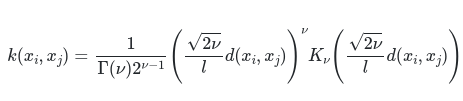

In [74]:
def train_gp(X_train, y_train):
  from sklearn.gaussian_process import GaussianProcessRegressor
  from sklearn.gaussian_process.kernels import Matern

  kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
  gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=0).fit(X_train, y_train)
  return gpr

gpr = train_gp(X_train, y_train)
r2_test = gpr.score(X_test, y_test)
print('R2 for Test data: {}'.format(r2_test))

R2 for Test data: 0.9753063612921089


# p-Value and ANOVA

Example from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html \\
Intuition: https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w \\

In [ ]:
f_stat, p_val = f_regression(X_train, y_train)
print(f_stat)
print()
print(p_val)

[23.81702706  9.54253105 23.03769415  8.52436021  0.16074755  2.33534826
  2.46413992  6.22919137  2.68867538]

[4.55546206e-06 2.67047841e-03 6.28108989e-06 4.42727135e-03
 6.89419463e-01 1.29973780e-01 1.19980724e-01 1.43880487e-02
 1.04554728e-01]


In [ ]:
k = 6
anova_filter = SelectKBest(f_regression, k=k)
X_new = anova_filter.fit_transform(X_train, y_train)

print('Shape of X: ', X_train.shape)
print('Shape of X after ANOVA: ', X_new.shape)
idx = np.argsort(anova_filter.scores_)[::-1][:k]+1 #+1 because of No. - Attribute
print('Selected Features: ', data.columns[idx])
idx = np.argsort(anova_filter.scores_)[::-1][:k]

Shape of X:  (92, 9)
Shape of X after ANOVA:  (92, 6)
Selected Features:  Index(['Cement', 'Fly ash', 'Slag', 'Water', 'SLUMP(cm)', 'FLOW(cm)'], dtype='object')


# Lasso


1.   Lasso Übersicht
2.   LassoCV (Gridsearch Equivalent)
3.   Lasso mit HPO (Hyperparameter Optimization mit Bayesian Optimization)
4.   Lasso mit NSGAII Hyperparameterauswahl 


**1. Lasso Übersicht**

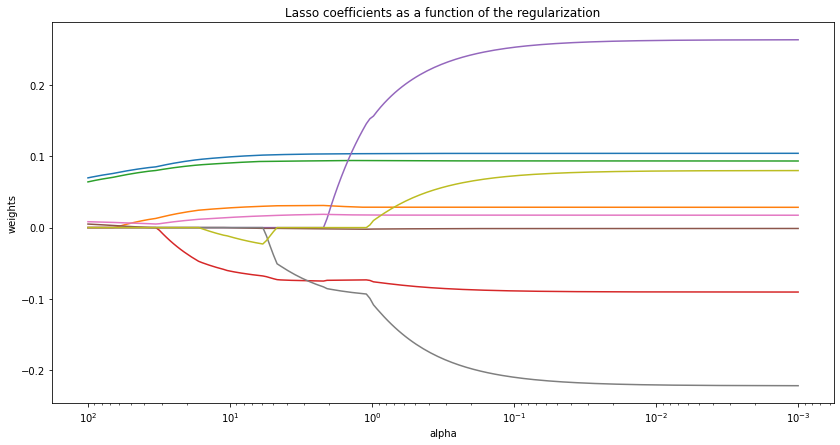

In [57]:
from sklearn.linear_model import Lasso
warnings.filterwarnings("ignore")
n_alphas = 200
alphas = np.logspace(-3, 2, n_alphas)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(14,7))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

**2. LassoCV (Gridsearch Equivalent)**

<BarContainer object of 9 artists>

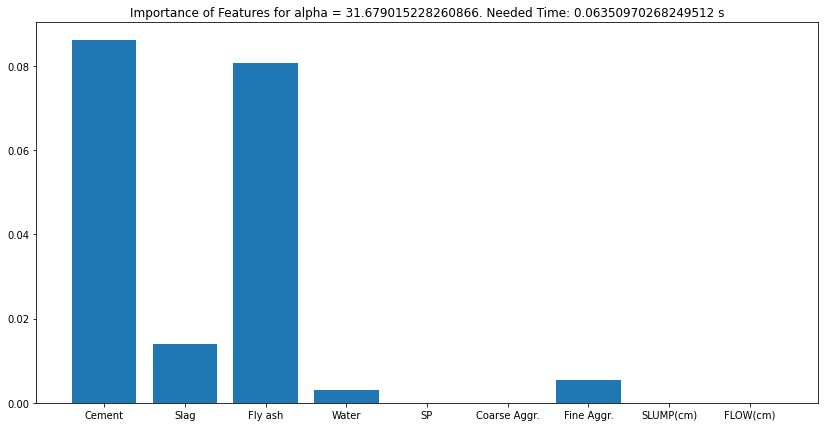

In [58]:
from sklearn.linear_model import LassoCV
start_time = time()
model = LassoCV(cv=3, fit_intercept=False).fit(X_train, y_train)
needed_time = time() - start_time
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(model.alpha_, needed_time))
plt.bar(data_cols, importance)
#plt.axhline(y=0.001,linewidth=1, color='r')

In [75]:
impIdx = np.nonzero(importance)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 5 Features.
R2 for Test data: 0.9684110210072067


**3. Lasso mit HPO (Hyperparameter Optimization mit Bayesian Optimization)** \\
Source Code: https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html \\
How it works: https://ax.dev/docs/bayesopt \\

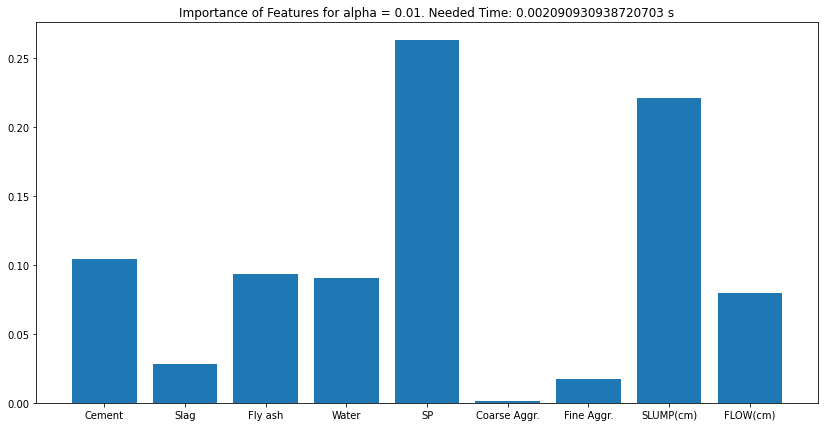

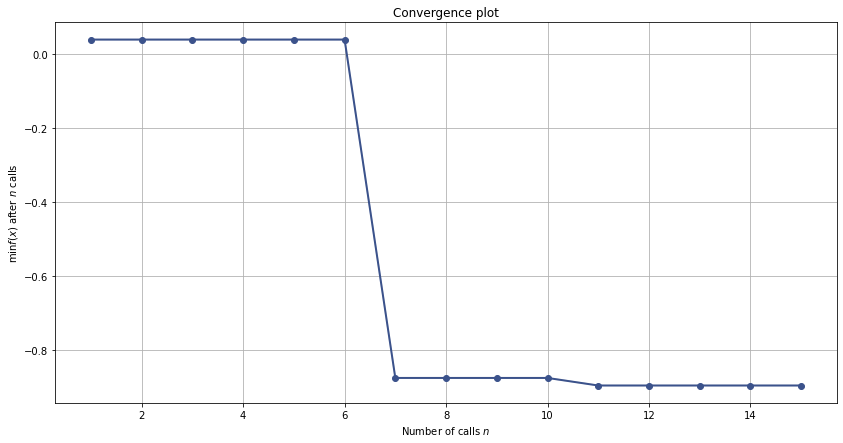

In [77]:
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_objective
from skopt.plots import plot_convergence
from sklearn.linear_model import Lasso

start_time = time()
opt = BayesSearchCV(
    Lasso(),
    {
        'alpha': Real(10E-3, 10E+2),
        'fit_intercept': ['False']
    },
    scoring='r2',
    n_iter=15,
    cv=3,
)
needed_time = time() - start_time
opt.fit(X_train, y_train)

alpha = opt.best_params_['alpha']

lasso = Lasso(alpha=alpha, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(lasso.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, needed_time))
plt.bar(data_cols, importance)
plt.figure(figsize=(14, 7))
plot_convergence(opt.optimizer_results_)

In [81]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 8 Features.
R2 for Test data: 0.9819852862817923


**4. Lasso mit NSGA II**

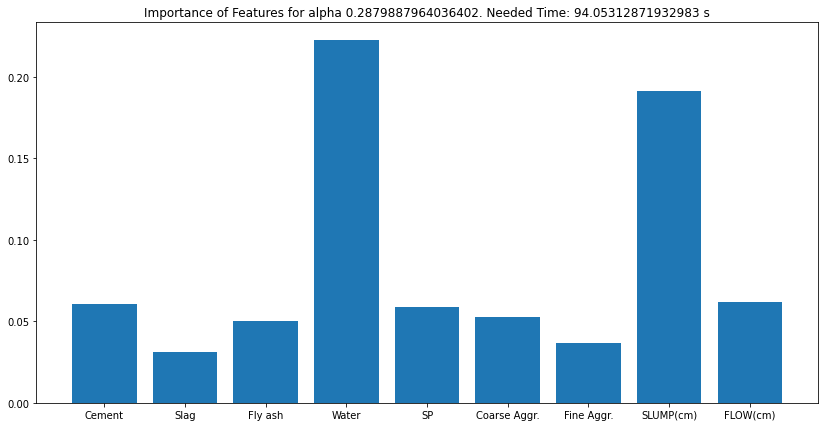

In [85]:
from sklearn.model_selection import cross_val_score
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from sklearn.linear_model import Lasso
from time import time

class MyProblem(ElementwiseProblem):

    def __init__(self, estimator):
        super().__init__(n_var=1,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([10E-3]),
                         xu=np.array([10E+2]))
        self.estimator = estimator

    def _evaluate(self, x, out, *args, **kwargs):
        lasso = self.estimator(alpha=x[0], fit_intercept=False)
        r2 = cross_val_score(lasso, X_train, y_train, cv=3, scoring='r2')
        score = 1 - np.abs(r2.mean())

        out["F"] = [score]


problem = MyProblem(estimator=Lasso)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx"),
    mutation=get_mutation("real_pm"),
    eliminate_duplicates=True)

termination = get_termination("n_gen", 300)

start_time = time()

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)
needed_time = time() - start_time

X_ = res.X  # minimize returns result objects
F_ = res.F

for alpha in X_:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    importance = np.abs(lasso.coef_)
    plt.figure(figsize=(14, 7))
    plt.bar(data_cols, importance)
    plt.title('Importance of Features for alpha {}. Needed Time: {} s'.format(alpha, needed_time))
    plt.show()

In [86]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 9 Features.
R2 for Test data: 0.9753063612921089


# Ridge Regression

How to decide which Features to select? https://stats.stackexchange.com/questions/506397/how-to-select-the-best-feature-set-from-ridge-regression

Wie genau funktioniert Ridge Regression? Welche Faktoren sind wichtig? Hyperparameterauswahl mit AutoML und NSGAII - GridSearch ist veraltet.

1.   Ridge Übersicht
2.   RidgeCV (Gridsearch Equivalent)
3.   Ridge mit HPO (Hyperparameter Optimization mit Bayesian Optimization)
4.   Ridge mit NSGAII Hyperparameterauswahl 

**1. Ridge Übersicht**

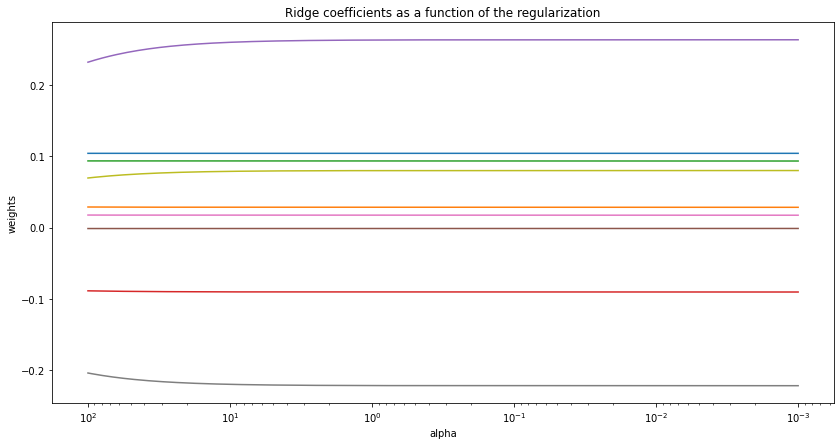

In [87]:
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore")
n_alphas = 200
alphas = np.logspace(-3, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

plt.figure(figsize=(14,7))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

**2. RidgeCV (Gridsearch Equivalent)**

<BarContainer object of 9 artists>

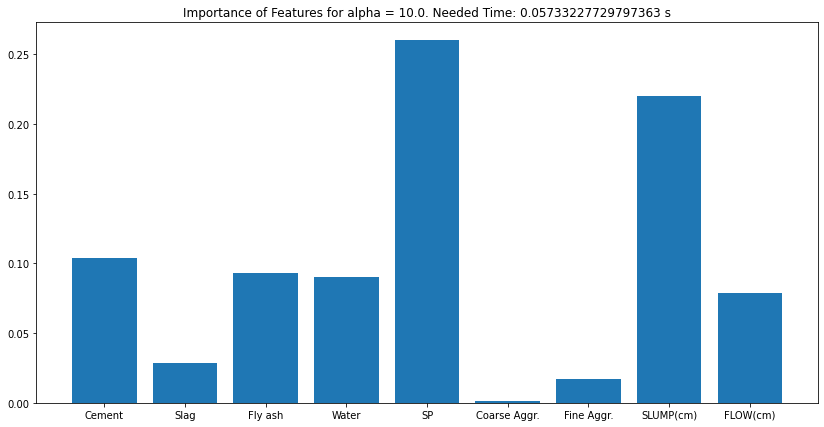

In [88]:
from sklearn.linear_model import RidgeCV
start_time = time()
model = RidgeCV(cv=3, fit_intercept=False).fit(X_train, y_train)
needed_time = time() - start_time
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(model.alpha_, needed_time))
plt.bar(data_cols, importance)

In [89]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 8 Features.
R2 for Test data: 0.9819852862817923


**3. Ridge mit HPO (Hyperparameter Optimization mit Bayesian Optimization)**

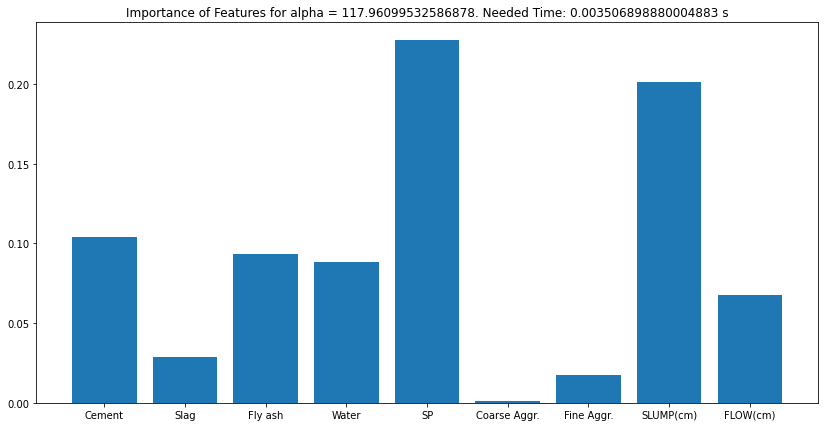

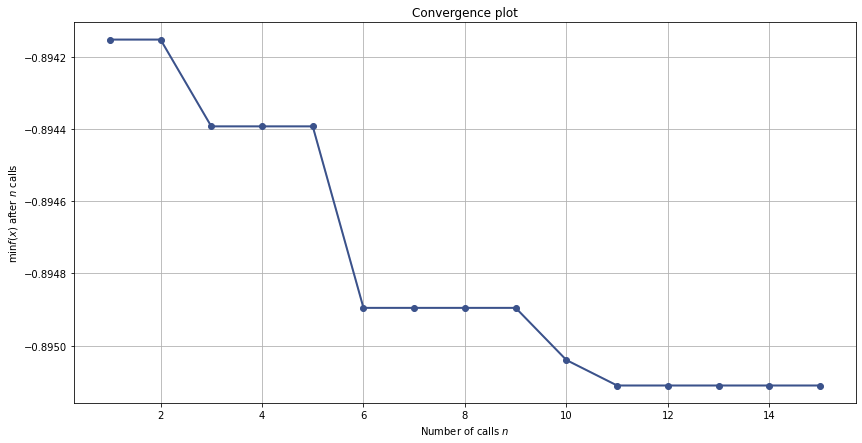

In [90]:
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_objective
from skopt.plots import plot_convergence
from sklearn.linear_model import Ridge

start_time = time()
opt = BayesSearchCV(
    Ridge(),
    {
        'alpha': Real(10E-3, 10E+2),
        'fit_intercept': ['False']
    },
    scoring='r2',
    n_iter=15,
    cv=3,
)
end_time = time() - start_time

opt.fit(X_train, y_train)

alpha = opt.best_params_['alpha']

ridge = Ridge(alpha=alpha, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, end_time))
plt.bar(data_cols, importance)
plt.figure(figsize=(14, 7))
plot_convergence(opt.optimizer_results_)

In [91]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 8 Features.
R2 for Test data: 0.9819852862817923


**4. Ridge mit NSGAII Hyperparameterauswahl**

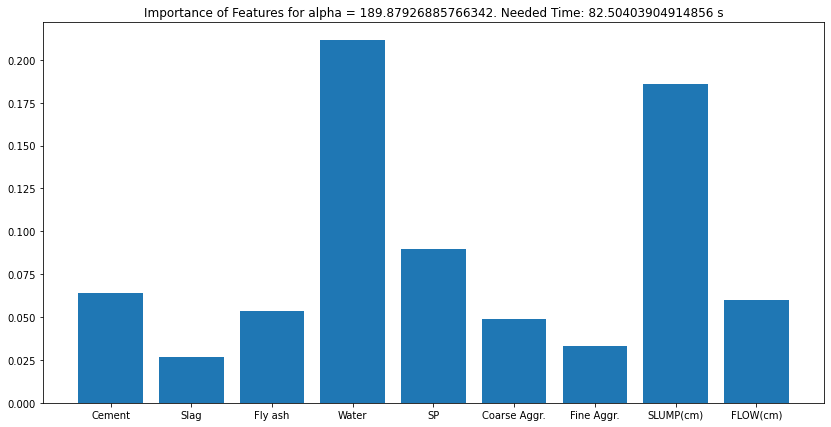

In [92]:
from sklearn.model_selection import cross_val_score
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from sklearn.linear_model import Ridge
from time import time

class MyProblem(ElementwiseProblem):

    def __init__(self, estimator):
        super().__init__(n_var=1,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([10E-3]),
                         xu=np.array([10E+2]))
        self.estimator = estimator

    def _evaluate(self, x, out, *args, **kwargs):
        estimator = self.estimator(alpha=x[0], fit_intercept=False)
        r2 = cross_val_score(estimator, X_train, y_train, cv=3, scoring='r2')
        score = 1 - np.abs(r2.mean())

        out["F"] = [score]


problem = MyProblem(estimator=Ridge)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx"),
    mutation=get_mutation("real_pm"),
    eliminate_duplicates=True)

termination = get_termination("n_gen", 300)

start_time = time()

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)
end_time = time() - start_time
X_ = res.X  # minimize returns result objects
F_ = res.F

for alpha in X_:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    importance = np.abs(ridge.coef_)
    plt.figure(figsize=(14, 7))
    plt.bar(data_cols, importance)
    plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, end_time))
    plt.show()

In [96]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 9 Features.
R2 for Test data: 0.9753063612921089


# ElasticNet
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

1.   ElasticNet Übersicht
2.   ElasticNetCV (Gridsearch Equivalent)
3.   ElasticNet mit HPO (Hyperparameter Optimization mit Bayesian Optimization)
4.   ElasticNet mit NSGAII Hyperparameterauswahl 

**1. ElasticNet Übersicht**



In [97]:
from sklearn.linear_model import ElasticNet
from ipywidgets import interact

warnings.filterwarnings("ignore")
n_alphas = 200
alphas = np.logspace(-3, 2, n_alphas)
@interact(l1_ratio=(0.1, 1))
def plot_coeff(l1_ratio=0.5):
  coefs = []
  for a in alphas:
      model = ElasticNet(alpha=a, l1_ratio=l1_ratio, fit_intercept=False)
      model.fit(X_train, y_train)
      coefs.append(model.coef_)

  plt.figure(figsize=(14,7))
  ax = plt.gca()
  ax.plot(alphas, coefs)
  ax.set_xscale("log")
  ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
  plt.xlabel("alpha")
  plt.ylabel("weights")
  plt.title("ElasticNet coefficients as a function of the regularization for l1_ratio = {}".format(l1_ratio))
  plt.axis("tight")
  plt.show()

interactive(children=(FloatSlider(value=0.5, description='l1_ratio', max=1.0, min=0.1), Output()), _dom_classe…

****2. ElasticNetCV (Gridsearch Equivalent)****

<BarContainer object of 9 artists>

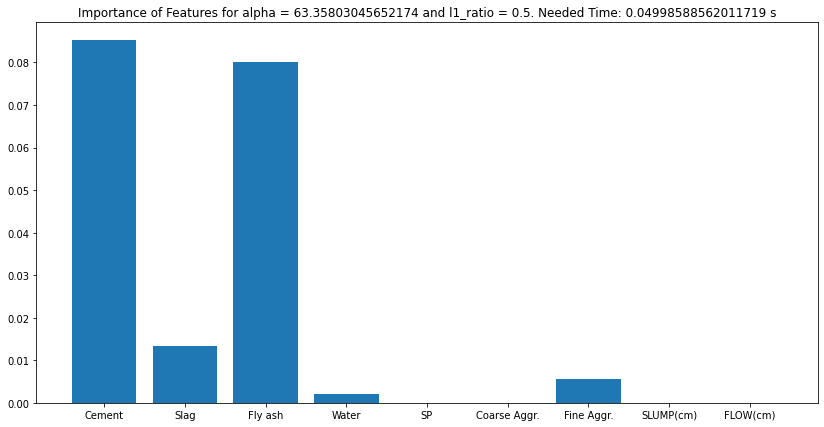

In [98]:
from sklearn.linear_model import ElasticNetCV
start_time = time()
model = ElasticNetCV(cv=3, n_alphas=100, fit_intercept=False).fit(X_train, y_train)
needed_time = time() - start_time
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {} and l1_ratio = {}. Needed Time: {} s'.format(model.alpha_, model.l1_ratio_, needed_time))
plt.bar(data_cols, importance)

In [100]:
impIdx = np.nonzero(importance)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 5 Features.
R2 for Test data: 0.9684110210072067




**3. ElasticNet mit HPO (Hyperparameter Optimization mit Bayesian Optimization)**


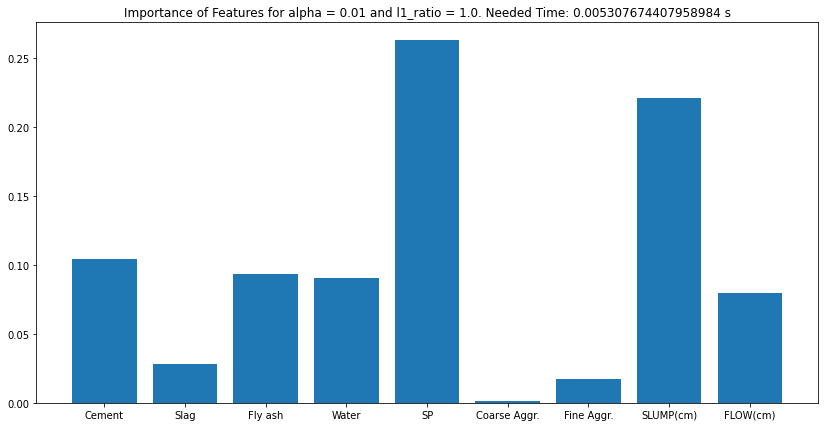

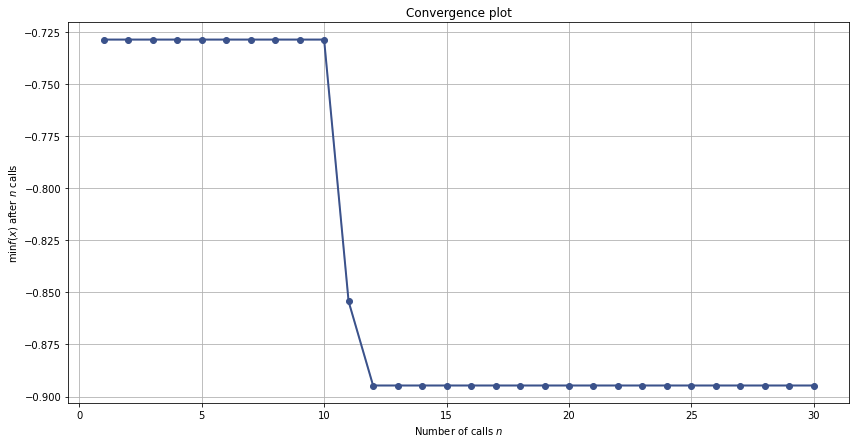

In [101]:
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_objective
from skopt.plots import plot_convergence
from sklearn.linear_model import ElasticNet

start_time = time()
opt = BayesSearchCV(
    ElasticNet(),
    {
        'alpha': Real(10E-3, 10E+2),
        'l1_ratio': Real(0, 1),
        'fit_intercept': ['False']
    },
    scoring='r2',
    n_iter=30,
    cv=3,
)
end_time = time() - start_time

opt.fit(X_train, y_train)

alpha = opt.best_params_['alpha']
l1_ratio = opt.best_params_['l1_ratio']

elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(elastic.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {} and l1_ratio = {}. Needed Time: {} s'.format(alpha, l1_ratio, end_time))
plt.bar(data_cols, importance)
plt.figure(figsize=(14, 7))
plot_convergence(opt.optimizer_results_)

In [102]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 8 Features.
R2 for Test data: 0.9819852862817923


**4. ElasticNet mit NSGAII Hyperparameterauswahl**

In [ ]:
from sklearn.model_selection import cross_val_score
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from sklearn.linear_model import ElasticNet
from time import time

class MyProblem(ElementwiseProblem):

    def __init__(self, estimator):
        super().__init__(n_var=2,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([10E-3, 0.1]),
                         xu=np.array([10E+2, 1]))
        self.estimator = estimator

    def _evaluate(self, x, out, *args, **kwargs):
        estimator = self.estimator(alpha=x[0], l1_ratio = x[1], fit_intercept=False)
        r2 = cross_val_score(estimator, X_train, y_train, cv=3, scoring='r2')
        score = 1 - np.abs(r2.mean())

        out["F"] = [score]


problem = MyProblem(estimator=ElasticNet)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx"),
    mutation=get_mutation("real_pm"),
    eliminate_duplicates=True)

termination = get_termination("n_gen", 300)

start_time = time()

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)
end_time = time() - start_time
X_ = res.X  # minimize returns result objects
F_ = res.F

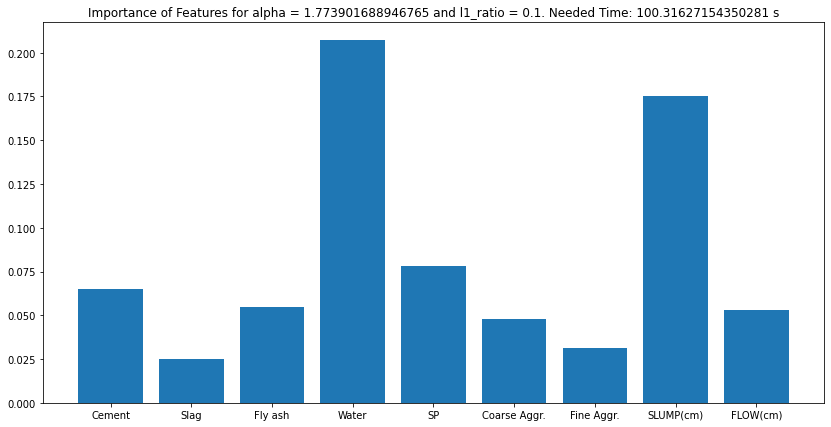

In [107]:
model = ElasticNet(alpha=X_[0][0], l1_ratio=X_[0][1]).fit(X_train, y_train)
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.bar(data_cols, importance)
plt.title('Importance of Features for alpha = {} and l1_ratio = {}. Needed Time: {} s'.format(X_[0][0], X_[0][1], end_time))
plt.show()

In [108]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 9 Features.
R2 for Test data: 0.9753063612921089
